In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [ ]:

run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

def preprocess(data):
    # data = detrend(data, axis=0)
    # epsilon = 1e-9
    # data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted
    
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices][:, 100:350]
                right_input_LFP_attleft = right_input_LFP[left_indices][:, 100:350]
                attention_LFP_attleft = attention_LFP[left_indices][:, 100:350]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices][:, 100:350]
                right_input_LFP_attright = right_input_LFP[right_indices][:, 100:350]
                attention_LFP_attright = attention_LFP[right_indices][:, 100:350]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 14.22 seconds
Dataset 1 processed in 1.24 seconds
Dataset 2 loaded in 4.83 seconds
Dataset 2 processed in 0.50 seconds
Dataset 4 loaded in 6.03 seconds
Dataset 4 processed in 0.56 seconds
Dataset 8 loaded in 7.66 seconds
Dataset 8 processed in 0.44 seconds
Dataset 14 loaded in 6.49 seconds
Dataset 14 processed in 0.52 seconds
Dataset 15 loaded in 4.76 seconds
Dataset 15 processed in 0.40 seconds
Dataset 20 loaded in 5.46 seconds
Dataset 20 processed in 0.36 seconds
Dataset 23 loaded in 4.48 seconds
Dataset 23 processed in 0.43 seconds
Total load time = 58.39 seconds


In [2]:

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)


for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])


for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

   
n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


In [ ]:

#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}


wsmi_means = copy.deepcopy(lr_split_structure)
wsmi_stdevs = copy.deepcopy(lr_split_structure)


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    

        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        #print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        #print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        #print("raw_data_left =", raw_left)


        #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        events_left = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.5,  baseline=None, preload=True)
       
        # epochs_left.plot(n_channels=3, scalings = 'auto', title="Attention Left")
        # plt.show()

        kernel = 3
        taus = [8, 16, 32, 64]  # in ms
        wsmi_results = {'left': {}, 'right': {}}

        for tau in taus:
            tau_samples = int(tau / (1000 / sfreq))
                        
            wsmi_left, _, _, _ = epochs_compute_wsmi(
                epochs_left, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
            )
            wsmi_results['left'][tau] = wsmi_left
            #this containts the data for wsmi at a given tau given attending left. 

            #-wsmi has been calculated for a given pair, for all values tau -- want to extrace these values and then store them
        wsmi_run_time = time.time() - wsmi_start
        
          
        for tau in taus:
            wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'].append(np.mean(wsmi_results['left'][tau][0, 2, :]))  #taking the mean across trials
            wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'].append(np.mean(wsmi_results['left'][tau][1, 2, :]))
    
            wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'].append(np.std(wsmi_results['left'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'].append(np.std(wsmi_results['left'][tau][1, 2, :], ddof = 1))

    print(f"wSMI calculated for all left {class_left} in {wsmi_run_time:.2f} seconds")


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            continue        

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}']            
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        events_right = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 


        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.25,  baseline=None, preload=True)
        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.25, baseline=None, preload=True)
        
        # epochs_left.plot(n_channels=3, scalings = 'auto', title="Attention Left")
        # plt.show()

        kernel = 3
        taus = [8, 16, 32, 64]  # in ms
        wsmi_results = {'left': {}, 'right': {}}

        for tau in taus:
            tau_samples = int(tau / (1000 / sfreq))
                        
            wsmi_right, _, _, _ = epochs_compute_wsmi(
                epochs_right, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
            )
            wsmi_results['right'][tau] = wsmi_right
        
        wsmi_run_time = time.time() - wsmi_start

        for tau in taus:

            wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'].append(np.mean(wsmi_results['right'][tau][0, 2, :]))
            wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'].append(np.mean(wsmi_results['right'][tau][1, 2, :]))

            wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'].append(np.std(wsmi_results['right'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'].append(np.std(wsmi_results['right'][tau][1, 2, :], ddof = 1))

    print(f"wSMI calculated for all right {class_left} in {wsmi_run_time:.2f} seconds")

            #e.g. each class pair should get 4 values for each tau


run_time = time.time() - run_time
print(f"Total run time = {run_time:.2f} seconds")

wSMI calculated for all left 0 in 2.76 seconds
wSMI calculated for all left 1 in 3.06 seconds
wSMI calculated for all left 2 in 2.54 seconds
wSMI calculated for all left 3 in 2.42 seconds
wSMI calculated for all left 4 in 2.41 seconds
wSMI calculated for all left 5 in 2.61 seconds
wSMI calculated for all left 6 in 2.61 seconds
wSMI calculated for all left 7 in 2.53 seconds
wSMI calculated for all left 8 in 2.65 seconds
wSMI calculated for all left 9 in 2.53 seconds
wSMI calculated for all left 10 in 2.71 seconds
wSMI calculated for all left 11 in 2.90 seconds
wSMI calculated for all left 12 in 2.66 seconds
wSMI calculated for all left 13 in 2.80 seconds
wSMI calculated for all left 14 in 3.09 seconds
wSMI calculated for all left 15 in 2.66 seconds
wSMI calculated for all left 16 in 3.07 seconds
wSMI calculated for all left 17 in 2.61 seconds
wSMI calculated for all left 18 in 2.86 seconds
wSMI calculated for all left 19 in 2.54 seconds
wSMI calculated for all right 0 in 1.19 seconds
wS

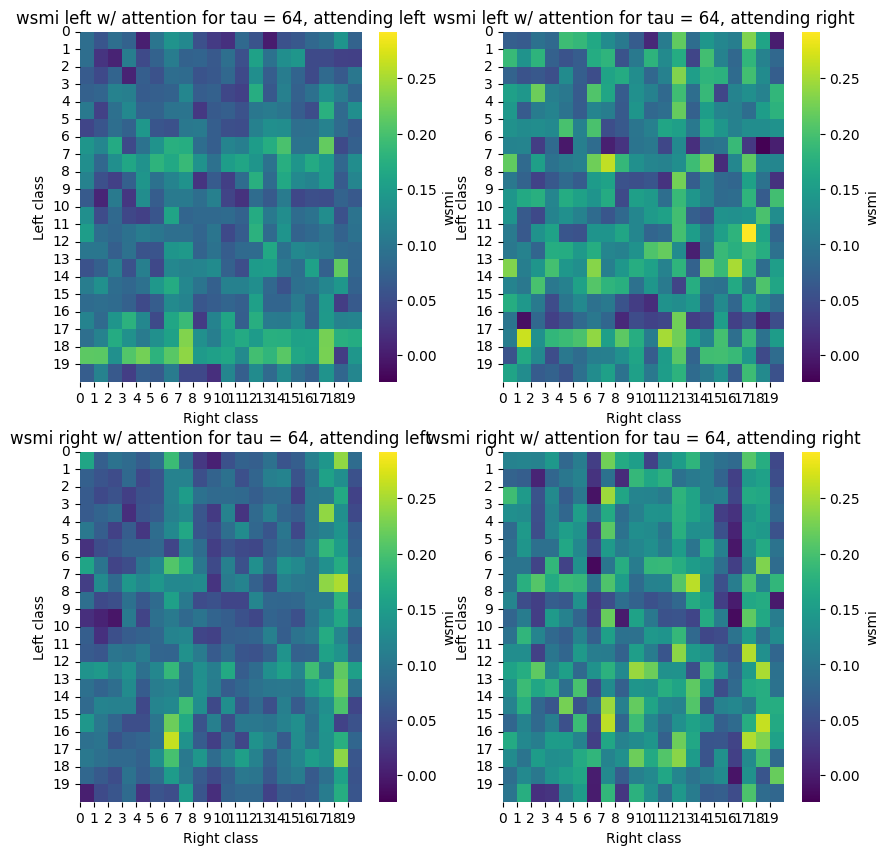

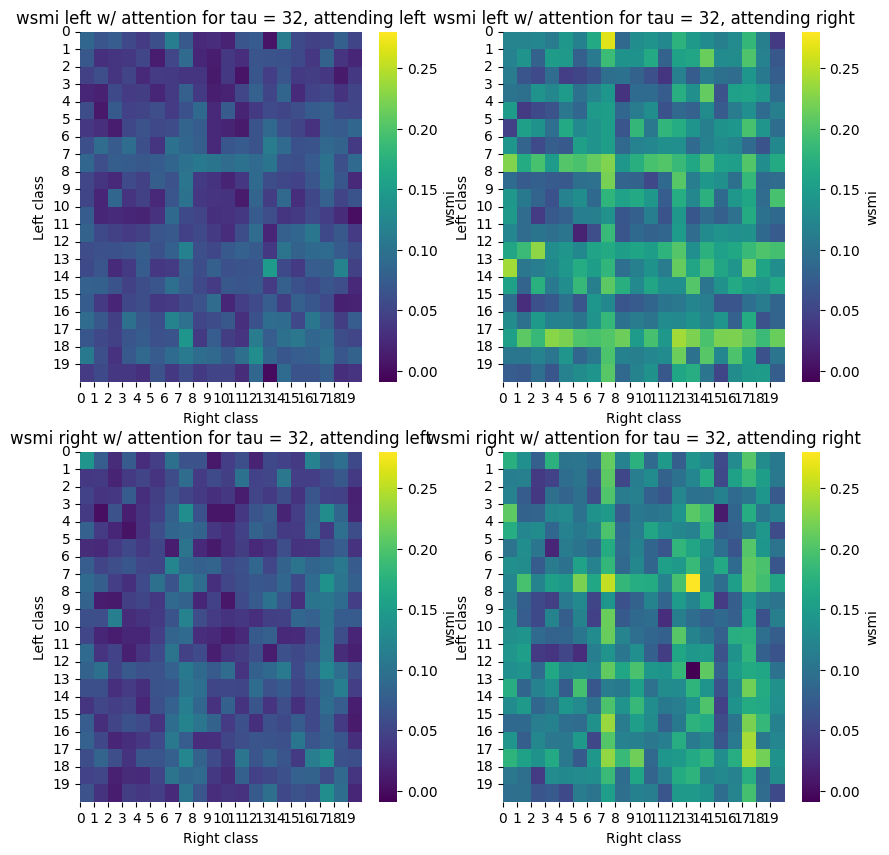

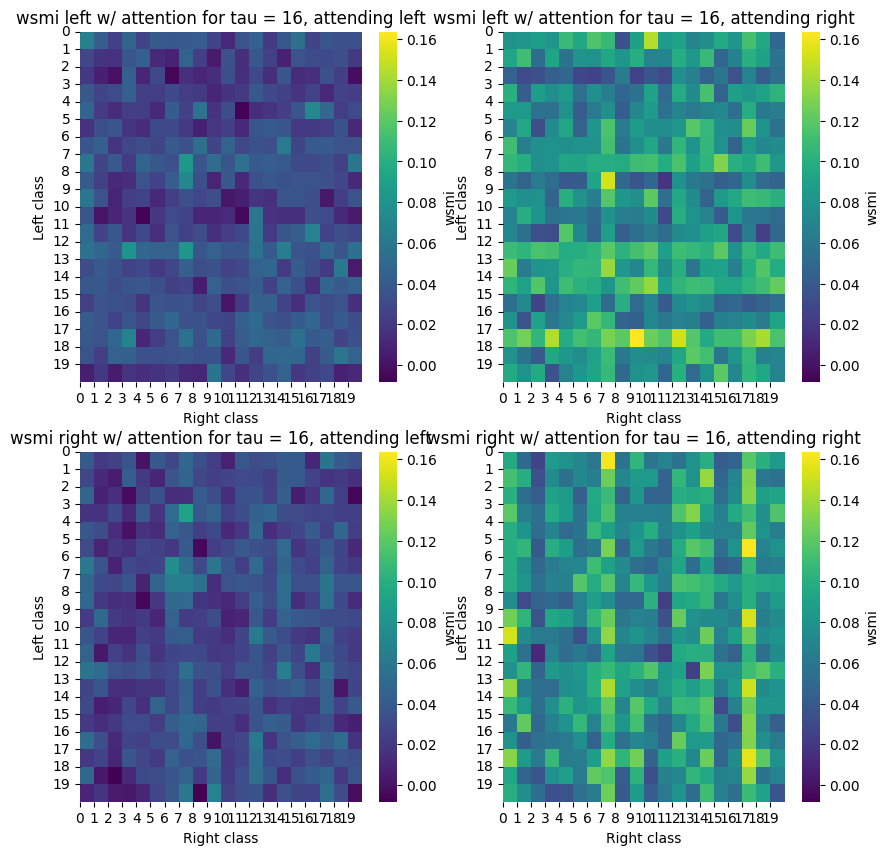

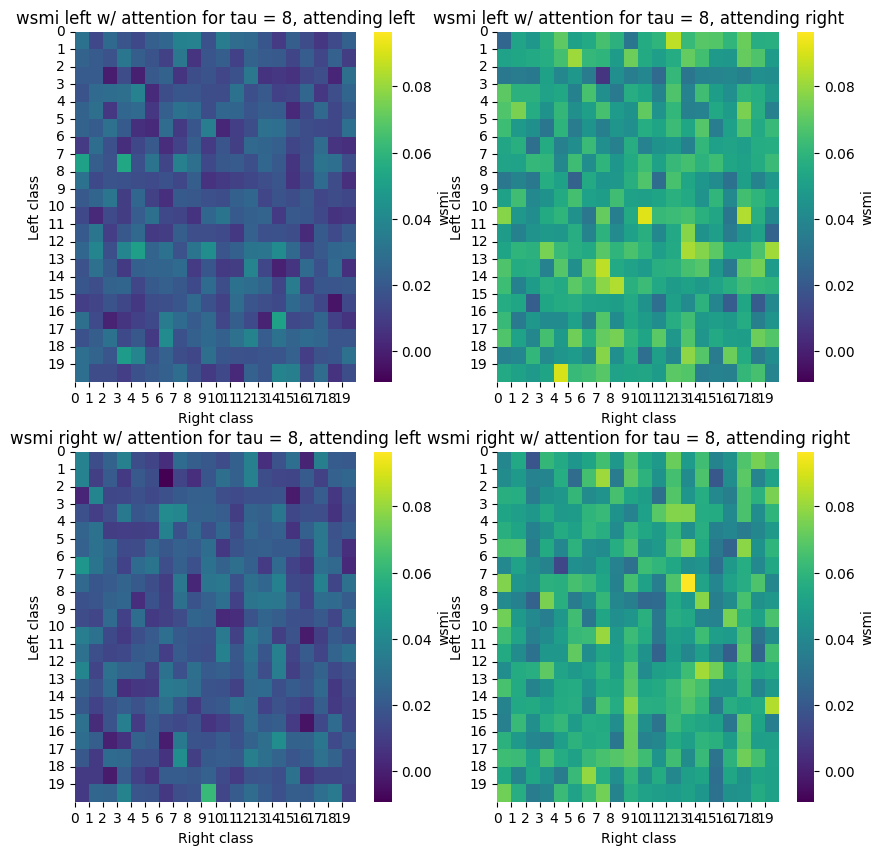

In [4]:
#--------plotting the results-------------
results_to_plot = {tau: copy.deepcopy(lr_split_structure) for tau in [8, 16, 32, 64]}

for tau, idx in zip([8, 16, 32, 64], range(4)):
    for class_left in classes_left:
        for class_right in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[tau][f'left_class_{class_left}'][f'right_class_{class_right}'][key] = wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'][key][idx]

#==============================plotting================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin_64, vmax_64 = calculate_vmin_vmax(results_to_plot[64], classes_left, classes_right)
vmin_32, vmax_32 = calculate_vmin_vmax(results_to_plot[32], classes_left, classes_right)
vmin_16, vmax_16 = calculate_vmin_vmax(results_to_plot[16], classes_left, classes_right)
vmin_8, vmax_8 = calculate_vmin_vmax(results_to_plot[8], classes_left, classes_right)


def plot_4_hist(data, vmin, vmax, tau):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] for class_right in classes_right] for class_left in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[0,0].set_xticks(np.arange(0, 20))
    ax[0,0].set_yticks(np.arange(0, 20))
    ax[0,0].set_xticklabels(classes_right)
    ax[0,0].set_yticklabels(classes_left)
    ax[0,0].set_xlabel('Right class')
    ax[0,0].set_ylabel('Left class')
    ax[0,0].set_title(f'wsmi left w/ attention for tau = {tau}, attending left')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[1,0].set_xticks(np.arange(0, 20))
    ax[1,0].set_yticks(np.arange(0, 20))
    ax[1,0].set_xticklabels(classes_right)
    ax[1,0].set_yticklabels(classes_left)
    ax[1,0].set_xlabel('Right class')
    ax[1,0].set_ylabel('Left class')
    ax[1,0].set_title(f'wsmi right w/ attention for tau = {tau}, attending left')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] for class_right in classes_right] for class_left in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[0,1].set_xticks(np.arange(0, 20))
    ax[0,1].set_yticks(np.arange(0, 20))
    ax[0,1].set_xticklabels(classes_right)
    ax[0,1].set_yticklabels(classes_left)
    ax[0,1].set_xlabel('Right class')
    ax[0,1].set_ylabel('Left class')
    ax[0,1].set_title(f'wsmi left w/ attention for tau = {tau}, attending right')

    sns.heatmap(np.array([[data[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] for class_right in classes_right] for class_left in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[1,1].set_xticks(np.arange(0, 20))
    ax[1,1].set_yticks(np.arange(0, 20))
    ax[1,1].set_xticklabels(classes_right)
    ax[1,1].set_yticklabels(classes_left)
    ax[1,1].set_xlabel('Right class')
    ax[1,1].set_ylabel('Left class')
    ax[1,1].set_title(f'wsmi right w/ attention for tau = {tau}, attending right')

    plt.show()

plot_4_hist(results_to_plot[64], vmin_64, vmax_64, 64)
plot_4_hist(results_to_plot[32], vmin_32, vmax_32, 32)
plot_4_hist(results_to_plot[16], vmin_16, vmax_16, 16)
plot_4_hist(results_to_plot[8], vmin_8, vmax_8, 8)

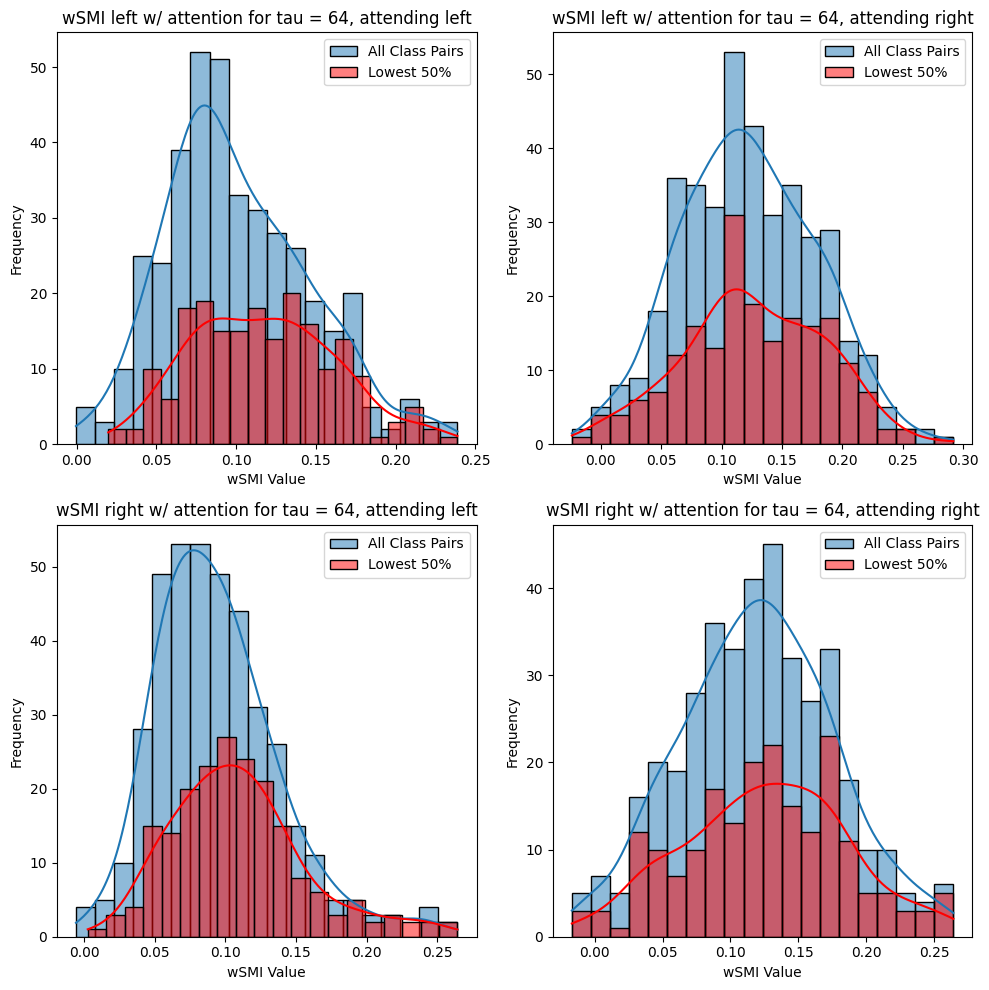

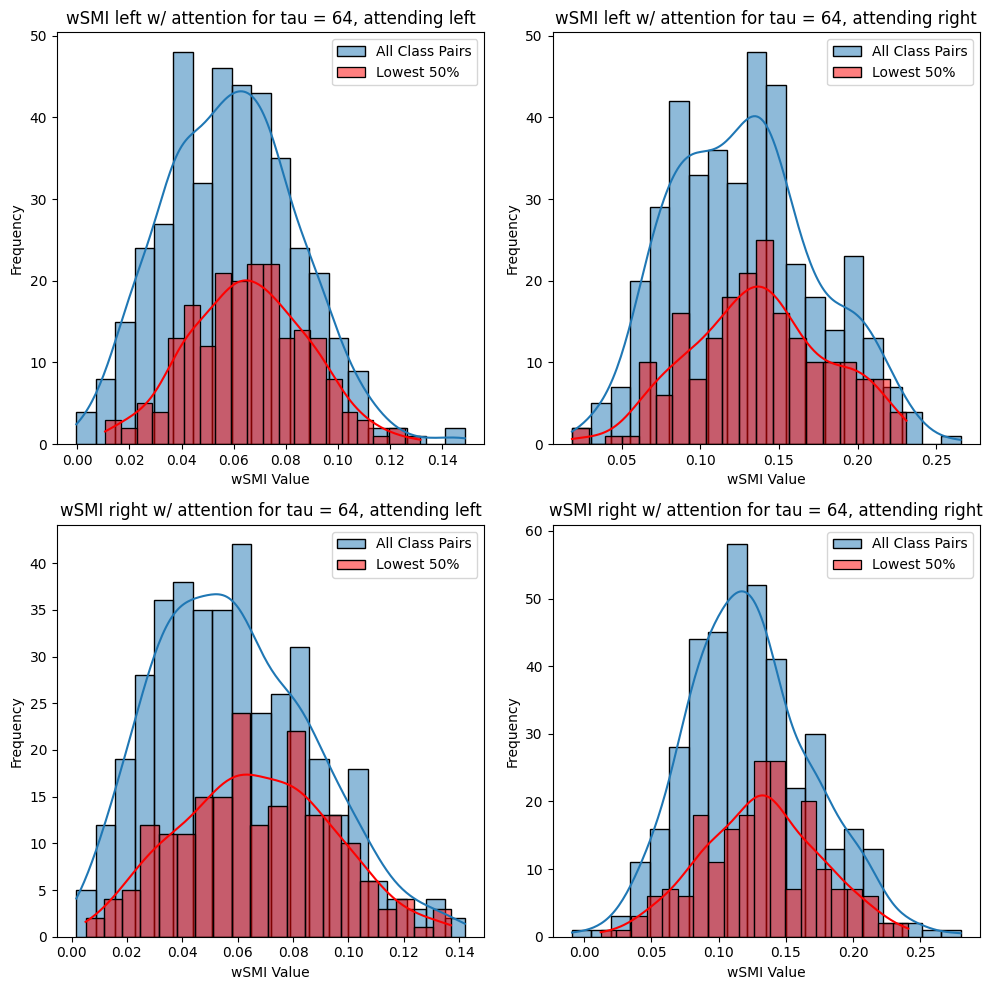

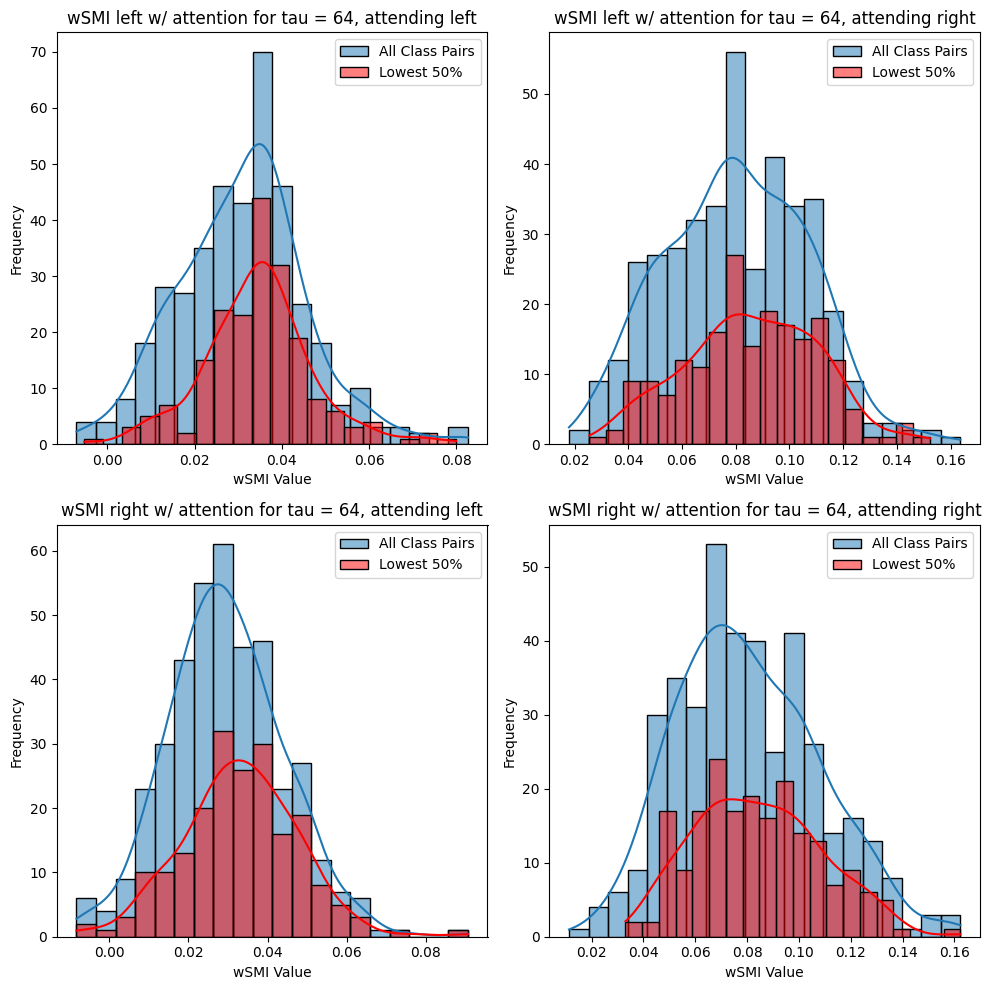

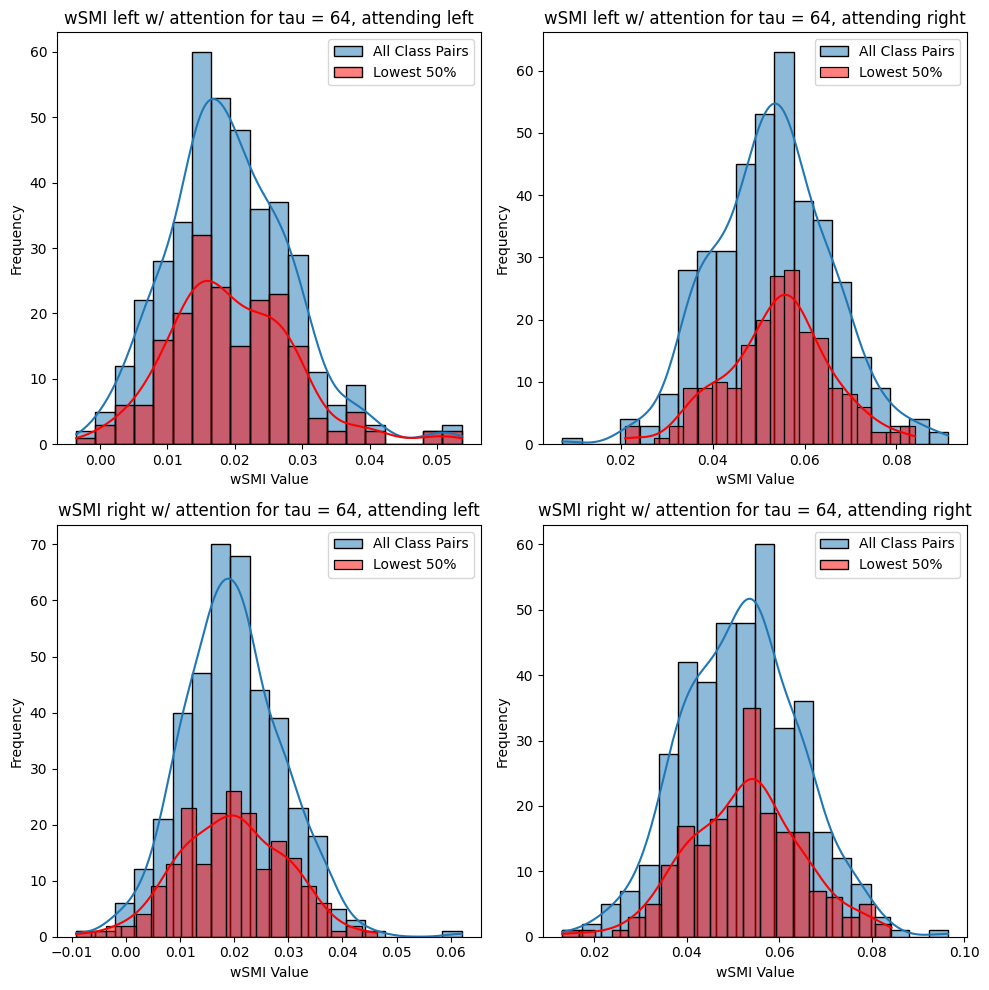

In [5]:
lowest_classes =  [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7)), (np.int64(12), np.int64(9)), (np.int64(6), np.int64(13)), (np.int64(12), np.int64(4)), (np.int64(7), np.int64(3)), (np.int64(6), np.int64(9)), (np.int64(9), np.int64(6)), (np.int64(13), np.int64(6)), (np.int64(15), np.int64(17)), (np.int64(10), np.int64(6)), (np.int64(8), np.int64(4)), (np.int64(11), np.int64(6)), (np.int64(6), np.int64(11)), (np.int64(6), np.int64(1)), (np.int64(5), np.int64(6)), (np.int64(1), np.int64(6)), (np.int64(14), np.int64(16)), (np.int64(15), np.int64(0)), (np.int64(6), np.int64(0)), (np.int64(17), np.int64(15)), (np.int64(5), np.int64(18)), (np.int64(6), np.int64(14)), (np.int64(4), np.int64(6)), (np.int64(14), np.int64(11)), (np.int64(13), np.int64(8)), (np.int64(7), np.int64(15)), (np.int64(14), np.int64(6)), (np.int64(10), np.int64(14)), (np.int64(7), np.int64(2)), (np.int64(14), np.int64(10)), (np.int64(13), np.int64(16)), (np.int64(1), np.int64(14)), (np.int64(17), np.int64(11)), (np.int64(17), np.int64(10)), (np.int64(3), np.int64(6)), (np.int64(8), np.int64(13)), (np.int64(11), np.int64(17)), (np.int64(0), np.int64(1)), (np.int64(6), np.int64(7)), (np.int64(18), np.int64(16)), (np.int64(11), np.int64(15)), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(18)), (np.int64(6), np.int64(15)), (np.int64(4), np.int64(12)), (np.int64(11), np.int64(0)), (np.int64(0), np.int64(6)), (np.int64(6), np.int64(4)), (np.int64(6), np.int64(19)), (np.int64(4), np.int64(8)), (np.int64(0), np.int64(3)), (np.int64(15), np.int64(12)), (np.int64(0), np.int64(16)), (np.int64(6), np.int64(3)), (np.int64(1), np.int64(15)), (np.int64(3), np.int64(2)), (np.int64(16), np.int64(3)), (np.int64(16), np.int64(4)), (np.int64(17), np.int64(2)), (np.int64(0), np.int64(11)), (np.int64(5), np.int64(12)), (np.int64(15), np.int64(6)), (np.int64(5), np.int64(17)), (np.int64(13), np.int64(15)), (np.int64(11), np.int64(4)), (np.int64(4), np.int64(10)), (np.int64(12), np.int64(2)), (np.int64(15), np.int64(7)), (np.int64(8), np.int64(5)), (np.int64(2), np.int64(8)), (np.int64(15), np.int64(5)), (np.int64(5), np.int64(14)), (np.int64(15), np.int64(9)), (np.int64(2), np.int64(16)), (np.int64(15), np.int64(13)), (np.int64(4), np.int64(15)), (np.int64(17), np.int64(19)), (np.int64(15), np.int64(1)), (np.int64(15), np.int64(16)), (np.int64(14), np.int64(1)), (np.int64(9), np.int64(15)), (np.int64(16), np.int64(18)), (np.int64(12), np.int64(15)), (np.int64(14), np.int64(5)), (np.int64(14), np.int64(19)), (np.int64(11), np.int64(5)), (np.int64(13), np.int64(12)), (np.int64(14), np.int64(9)), (np.int64(7), np.int64(4)), (np.int64(16), np.int64(2)), (np.int64(4), np.int64(16)), (np.int64(17), np.int64(3)), (np.int64(15), np.int64(11)), (np.int64(2), np.int64(17)), (np.int64(3), np.int64(17)), (np.int64(16), np.int64(13)), (np.int64(0), np.int64(19)), (np.int64(0), np.int64(10)), (np.int64(14), np.int64(4)), (np.int64(16), np.int64(6)), (np.int64(3), np.int64(15)), (np.int64(5), np.int64(11)), (np.int64(13), np.int64(11)), (np.int64(5), np.int64(10)), (np.int64(6), np.int64(16)), (np.int64(9), np.int64(4)), (np.int64(4), np.int64(14)), (np.int64(4), np.int64(3)), (np.int64(17), np.int64(5)), (np.int64(15), np.int64(3)), (np.int64(6), np.int64(6)), (np.int64(14), np.int64(2)), (np.int64(10), np.int64(17)), (np.int64(8), np.int64(15)), (np.int64(14), np.int64(3)), (np.int64(14), np.int64(0)), (np.int64(14), np.int64(7)), (np.int64(7), np.int64(17)), (np.int64(19), np.int64(0)), (np.int64(3), np.int64(14)), (np.int64(3), np.int64(3))]
results_to_plot_low = {tau: copy.deepcopy(lr_split_structure) for tau in [8, 16, 32, 64]}

for tau, idx in zip([8, 16, 32, 64], range(4)):
    for class_left in classes_left:
        for class_right in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[tau][f'left_class_{class_left}'][f'right_class_{class_right}'][key] = wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'][key][idx]


for tau, idx in zip([8, 16, 32, 64], range(4)):
    for class_left in classes_left:
        for class_right in classes_right:
            if (class_left, class_right) in lowest_classes:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}'][key] = wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'][key][idx]
            else:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}'][key] = -1



def hist_low_plot(data, data_low, tau):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the extracted wSMI values into 1D lists before plotting
    hist_values_all = [data[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                        for class_left in classes_left for class_right in classes_right if data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] != -1]

    sns.histplot(hist_values_all, ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[0, 0], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[0,0].set_title('wSMI left w/ attention for tau = 64, attending left')
    ax[0,0].set_xlabel('wSMI Value')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].legend()

    # Repeat for the other plots
    hist_values_all = [data[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                        for class_left in classes_left for class_right in classes_right if data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] != -1]

    sns.histplot(hist_values_all, ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[1, 0], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[1,0].set_title('wSMI right w/ attention for tau = 64, attending left')
    ax[1,0].set_xlabel('wSMI Value')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend()

    hist_values_all = [data[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                        for class_left in classes_left for class_right in classes_right if data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] != -1]

    sns.histplot(hist_values_all, ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[0, 1], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[0,1].set_title('wSMI left w/ attention for tau = 64, attending right')
    ax[0,1].set_xlabel('wSMI Value')
    ax[0,1].set_ylabel('Frequency')
    ax[0,1].legend()

    hist_values_all = [data[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                        for class_left in classes_left for class_right in classes_right]
    hist_values_low = [data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                        for class_left in classes_left for class_right in classes_right if data_low[tau][f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] != -1]

    sns.histplot(hist_values_all, ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[1, 1], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[1,1].set_title('wSMI right w/ attention for tau = 64, attending right')
    ax[1,1].set_xlabel('wSMI Value')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

hist_low_plot(results_to_plot, results_to_plot_low, 64)
hist_low_plot(results_to_plot, results_to_plot_low, 32)
hist_low_plot(results_to_plot, results_to_plot_low, 16)
hist_low_plot(results_to_plot, results_to_plot_low, 8)